In [5]:
using Pkg
Pkg.activate("../.."); # Actives the environment at the root of the project
# Using our Carbon-I and vSmartMOM packages (developed by our team)
using CarbonI, vSmartMOM,  ImageFiltering
# Using standard Julia packages for Linear albegra, Differentiation, etc.

using CairoMakie
include(joinpath("../../src/Plots", "CI_colorsNew.jl"))

  Activating project at `~/code/gitHub/CarbonI`


> Loading Methane Spectroscopy from a pre-computed cross section table (tools included in vSmartMOM) and then computing the cross section of CH<sub>4</sub>  at the temperature and pressure in the laboratory (WAGs)

In [3]:
# Load Cross section database
ch4 = vSmartMOM.load_interpolation_model(CarbonI.xs_folder*"/ch4_model.jld2")
co = vSmartMOM.load_interpolation_model(CarbonI.xs_folder*"/co_model.jld2")
co2 = vSmartMOM.load_interpolation_model(CarbonI.xs_folder*"/co2_model.jld2")
# Generate cross section at TestBed condition
p = 940.0 # Pressure in hPa
T = 295.0 # Temperature in K
Δwl = 0.005 # Resolution in nm
# Define high resolution wavelength grid (needs to be larger than the Carbon-I wavelength range to account for the SRF impact at the edges)
wl_grid_hr = 2030:Δwl:2398
xs_ch4  = reverse(vSmartMOM.absorption_cross_section(ch4, wl_grid_hr, p, T; wavelength_flag=true));
xs_co  = reverse(vSmartMOM.absorption_cross_section(co, wl_grid_hr, p, T; wavelength_flag=true));
xs_co2  = reverse(vSmartMOM.absorption_cross_section(co2, wl_grid_hr, p, T; wavelength_flag=true)); # Has to be reversed to match the order of the data (as table is in wavenumber)

> Define an Instrument function (using tools developed in Carbon-I), modeling the Spectral Response Function as a mix of two boxcar functions (for slit and detector pixel) as well as a Gaussian (for optical effects)

In [6]:
# Define an instrument (Convolution of 2 Box kernels with a Gaussian):
FWHM  = 0.65  # Full Width at Half Maximum in nm 
SSI  = 0.7   # Spectral Sampling Interval in nm
# Define the kernels:
# Spectral response function of the slit (2*SSI)
kern1 = CarbonI.box_kernel(2*SSI, Δwl)
# Spectral response function of the optics (Gaussian)
kern2 = CarbonI.gaussian_kernel(FWHM, Δwl)
# Spectral response function of the pixel (1*SSI)
kern3 = CarbonI.box_kernel(SSI, Δwl)
# Combine the kernels:
kernf = imfilter(imfilter(kern1, kern2), kern3)
# Generate the instrument (stores convolution kernel and wavelength grid):
CarbonI_SRF = CarbonI.KernelInstrument(kernf, collect(2036.7:SSI:2394.4));

> Model Transmission with a first guess of the vertical column density in the cell (8e19molec/cm2 here, which is roughly a double-pass through the atmosphere).

In [24]:
vcd_ch4 = 4e19 # molec/cm²
vcd_co  = 1e19
vcd_co2 =  8e21
# Transmission of entire cell:
T_CH4 = exp.(-2*xs_ch4*vcd_ch4)
T_CO2 = exp.(-2*xs_co2*vcd_co2)
T_CO = exp.(-2*xs_co*vcd_co)
# Transmission of instrument:
T_CH4_conv = CarbonI.conv_spectra(CarbonI_SRF, wl_grid_hr, T_CH4);
T_CO_conv = CarbonI.conv_spectra(CarbonI_SRF, wl_grid_hr, T_CO);
T_CO2_conv = CarbonI.conv_spectra(CarbonI_SRF, wl_grid_hr, T_CO2);

> Plot the **unfitted** modeled and measured spectra as well as the high resolution transmission computed before convolution to the Carbon-I grid

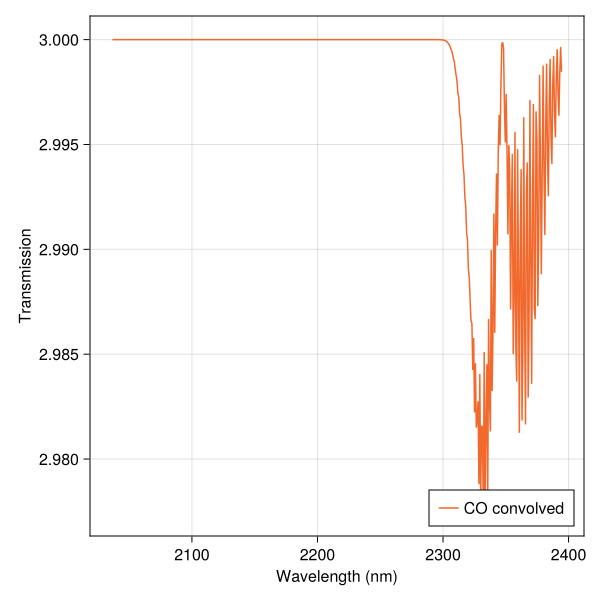

In [ ]:
f = Figure(resolution = (600, 600))
ax = Axis(f[1, 1], xlabel = "Wavelength (nm)", ylabel = "Transmission")

#lines!(ax, CarbonI_SRF.ν_out, T_CH4_conv.+1, color = CarbonI_colors[3], linewidth = 1.5, label = "CH₄ convolved")
#lines!(ax, CarbonI_SRF.ν_out, T_CO2_conv, color = CarbonI_colors[4], linewidth = 1.5, label = "CO₂ convolved")
lines!(ax, CarbonI_SRF.ν_out, T_CO_conv, color = CarbonI_colors[5], linewidth = 1.5, label = "CO convolved")
axislegend(position = :rb)
f
save( "../../plots/final/CH4_CO2_CO_Transmissions.pdf", f)
f